In [30]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [31]:
# read in data
with open('clean_data.pk1', 'rb') as picklefile:
    df = pickle.load(picklefile)

# look at data
print df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805 entries, 0 to 1804
Data columns (total 47 columns):
actors                    1805 non-null object
budget                    1805 non-null float64
director                  1805 non-null object
genre                     1805 non-null object
gross_domestic            1805 non-null float64
imdb_rating               1805 non-null float64
meta_score                1805 non-null float64
mpaa_rating               1805 non-null object
opening_weekend           1805 non-null float64
release_date              1805 non-null datetime64[ns]
runtime_mins              1805 non-null float64
title                     1805 non-null object
writer                    1805 non-null object
release_month             1805 non-null int64
release_year              1805 non-null int64
inf_budget                1805 non-null float64
inf_gross                 1805 non-null float64
inf_opening               1805 non-null float64
Intercept                 1805 n

,actors,budget,director,genre,gross_domestic,imdb_rating,meta_score,mpaa_rating,opening_weekend,release_date,...,horror,music,musical,mystery,romance,sci_fi,sport,thriller,war,western
0,"[Bruce Willis, Helen Mirren, Morgan Freeman]",58000000.0,[Robert Schwentke],"Action, Comedy, Crime, Thriller",90356857.0,71.0,60.0,PG-13,21761408.0,2010-10-15,...,0,0,0,0,0,0,0,1,0,0
1,"[Jay Baruchel, Gerard Butler, Christopher Mint...",165000000.0,[Dean DeBlois],"Animation, Action, Adventure, Comedy, Family,...",217387997.0,82.0,74.0,PG,43732319.0,2010-03-26,...,0,0,0,0,0,0,0,0,0,0
2,"[Adam Sandler, Salma Hayek, Kevin James]",80000000.0,[Dennis Dugan],"Comedy, Family",162001186.0,60.0,30.0,PG-13,40506562.0,2010-06-25,...,0,0,0,0,0,0,0,0,0,0
3,"[Jesse Eisenberg, Emma Stone, Woody Harrelson]",23600000.0,[Ruben Fleischer],"Adventure, Comedy, Horror, Sci-Fi",75590286.0,77.0,73.0,R,24733155.0,2009-10-02,...,1,0,0,0,0,1,0,0,0,0
4,"[Edward Asner, Jordan Nagai, John Ratzenberger]",175000000.0,[Pete Docter],"Animation, Adventure, Comedy, Family",292979556.0,83.0,88.0,PG,68108790.0,2009-05-29,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# drop columns not used for model
df_movies = df.drop(['actors', 'budget', 'director', 'genre','inf_opening', 'gross_domestic', 'opening_weekend', 'release_date', 'mpaa_rating', 'title', 'writer', 'release_year'], axis=1)
df_movies.head()

,imdb_rating,meta_score,runtime_mins,release_month,inf_budget,inf_gross,Intercept,mpaa_rating[T.PG],mpaa_rating[T.PG-13],mpaa_rating[T.R],...,horror,music,musical,mystery,romance,sci_fi,sport,thriller,war,western
0,71.0,60.0,111.0,10,6.383867e+07,9.945279e+07,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,82.0,74.0,98.0,3,1.816100e+08,2.392718e+08,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,60.0,30.0,102.0,6,8.805334e+07,1.783093e+08,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,77.0,73.0,88.0,10,2.640181e+07,8.456442e+07,1.0,0.0,0.0,1.0,...,1,0,0,0,0,1,0,0,0,0
4,83.0,88.0,96.0,5,1.957761e+08,3.277623e+08,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


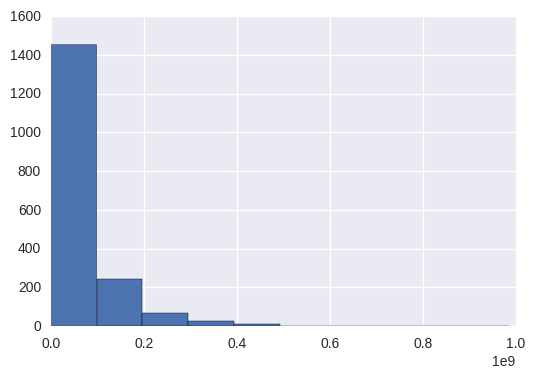

In [33]:
# check out distribution of target variable
df_movies.inf_gross.hist()

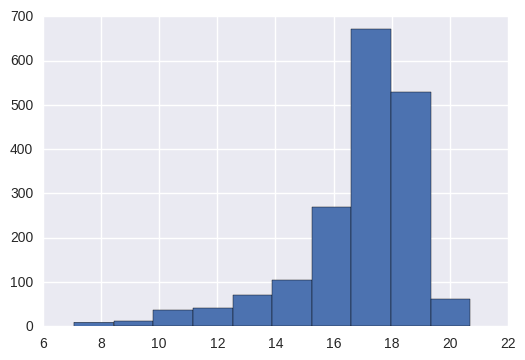

In [34]:
# noramlize the target variable
df_movies['log_inf_gross'] = np.log(df_movies.inf_gross)
df_movies.log_inf_gross.hist()

In [35]:
# rearrange the dataframe 
df_movies = df_movies.drop(['inf_gross'], axis=1)
cols = list(df_movies.columns)
new_cols = [cols[34]] + cols[0:34]
new_cols
df_movies = df_movies[new_cols]
df_movies.head()

,log_inf_gross,imdb_rating,meta_score,runtime_mins,release_month,inf_budget,Intercept,mpaa_rating[T.PG],mpaa_rating[T.PG-13],mpaa_rating[T.R],...,horror,music,musical,mystery,romance,sci_fi,sport,thriller,war,western
0,18.415194,71.0,60.0,111.0,10,6.383867e+07,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,19.293110,82.0,74.0,98.0,3,1.816100e+08,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,18.999030,60.0,30.0,102.0,6,8.805334e+07,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,18.253024,77.0,73.0,88.0,10,2.640181e+07,1.0,0.0,0.0,1.0,...,1,0,0,0,0,1,0,0,0,0
4,19.607799,83.0,88.0,96.0,5,1.957761e+08,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805 entries, 0 to 1804
Data columns (total 35 columns):
log_inf_gross             1805 non-null float64
imdb_rating               1805 non-null float64
meta_score                1805 non-null float64
runtime_mins              1805 non-null float64
release_month             1805 non-null int64
inf_budget                1805 non-null float64
Intercept                 1805 non-null float64
mpaa_rating[T.PG]         1805 non-null float64
mpaa_rating[T.PG-13]      1805 non-null float64
mpaa_rating[T.R]          1805 non-null float64
mpaa_rating[T.Unrated]    1805 non-null float64
actor_nom                 1805 non-null int64
director_nom              1805 non-null int64
writer_nom                1805 non-null int64
action                    1805 non-null int64
adventure                 1805 non-null int64
animation                 1805 non-null int64
biography                 1805 non-null int64
comedy                    1805 non-null int64

In [37]:
# seperate the target and predictor variables
y = df_movies['log_inf_gross']
x = df_movies[new_cols[1:]]

In [38]:
# preprocessing to standardize the data
X = preprocessing.normalize(x, axis=0, norm='max')
X = pd.DataFrame(X)
X.columns = x.columns
X.head()

,imdb_rating,meta_score,runtime_mins,release_month,inf_budget,Intercept,mpaa_rating[T.PG],mpaa_rating[T.PG-13],mpaa_rating[T.R],mpaa_rating[T.Unrated],...,horror,music,musical,mystery,romance,sci_fi,sport,thriller,war,western
0,0.788889,0.612245,0.506849,0.833333,0.213454,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.911111,0.755102,0.447489,0.250000,0.607241,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,0.306122,0.465753,0.500000,0.294420,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.855556,0.744898,0.401826,0.833333,0.088278,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.922222,0.897959,0.438356,0.416667,0.654607,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# check out correlations
movies = pd.concat([y, X], axis=1)
movies.corr()

,log_inf_gross,imdb_rating,meta_score,runtime_mins,release_month,inf_budget,Intercept,mpaa_rating[T.PG],mpaa_rating[T.PG-13],mpaa_rating[T.R],...,horror,music,musical,mystery,romance,sci_fi,sport,thriller,war,western
log_inf_gross,1.000000,0.118378,0.111294,0.236742,0.026266,0.526394,NaN,0.150892,0.240138,-0.320183,...,-0.048568,-0.013795,0.014320,-0.001597,-0.023483,0.108165,0.043543,-0.030043,-0.037708,-0.016166
imdb_rating,0.118378,1.000000,0.748272,0.429406,0.075158,0.085207,NaN,-0.099424,-0.111159,0.164907,...,-0.217195,-0.044008,0.019007,0.021957,-0.028097,-0.035628,0.005257,-0.031788,0.102474,0.031732
meta_score,0.111294,0.748272,1.000000,0.298355,0.073156,0.025795,NaN,-0.025183,-0.162076,0.155188,...,-0.176682,0.024734,0.050615,-0.016086,0.000341,-0.028189,-0.001099,-0.074792,0.073767,0.038820
runtime_mins,0.236742,0.429406,0.298355,1.000000,0.078615,0.392072,NaN,-0.132892,0.088238,0.022017,...,-0.187731,-0.019398,0.016022,0.016118,-0.009578,0.057417,0.072723,0.033068,0.194337,0.105473
release_month,0.026266,0.075158,0.073156,0.078615,1.000000,0.084767,NaN,0.008295,0.004865,-0.021726,...,-0.038580,0.030811,0.100040,0.003756,-0.008738,0.009053,0.010023,-0.028154,-0.006591,0.006081
inf_budget,0.526394,0.085207,0.025795,0.392072,0.084767,1.000000,NaN,0.131245,0.216610,-0.313715,...,-0.138081,-0.087569,0.002194,-0.026350,-0.122849,0.264571,-0.001903,0.013673,0.031598,0.056669
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mpaa_rating[T.PG],0.150892,-0.099424,-0.025183,-0.132892,0.008295,0.131245,NaN,1.000000,-0.289005,-0.313079,...,-0.111007,0.025026,0.036884,-0.050937,-0.012515,0.000985,0.088978,-0.194265,-0.066099,-0.038853
mpaa_rating[T.PG-13],0.240138,-0.111159,-0.162076,0.088238,0.004865,0.216610,NaN,-0.289005,1.000000,-0.773640,...,-0.068735,0.016510,-0.003995,0.001746,0.118143,0.127310,0.066286,-0.011280,-0.042705,0.004185
mpaa_rating[T.R],-0.320183,0.164907,0.155188,0.022017,-0.021726,-0.313715,NaN,-0.313079,-0.773640,1.000000,...,0.142086,-0.039851,-0.060904,0.033117,-0.104137,-0.112186,-0.132702,0.153193,0.085750,0.024923


In [40]:
# highest correlations to target variable (log_gross)
movies.corr()['log_inf_gross'].sort_values(ascending=False)

log_inf_gross             1.000000
inf_budget                0.526394
adventure                 0.266553
mpaa_rating[T.PG-13]      0.240138
runtime_mins              0.236742
action                    0.205082
family                    0.202929
mpaa_rating[T.PG]         0.150892
fantasy                   0.145485
animation                 0.143156
actor_nom                 0.125812
imdb_rating               0.118378
meta_score                0.111294
sci_fi                    0.108165
director_nom              0.089482
comedy                    0.060629
sport                     0.043543
writer_nom                0.040332
release_month             0.026266
musical                   0.014320
history                   0.010542
documentary               0.006632
mystery                  -0.001597
music                    -0.013795
western                  -0.016166
romance                  -0.023483
thriller                 -0.030043
war                      -0.037708
horror              

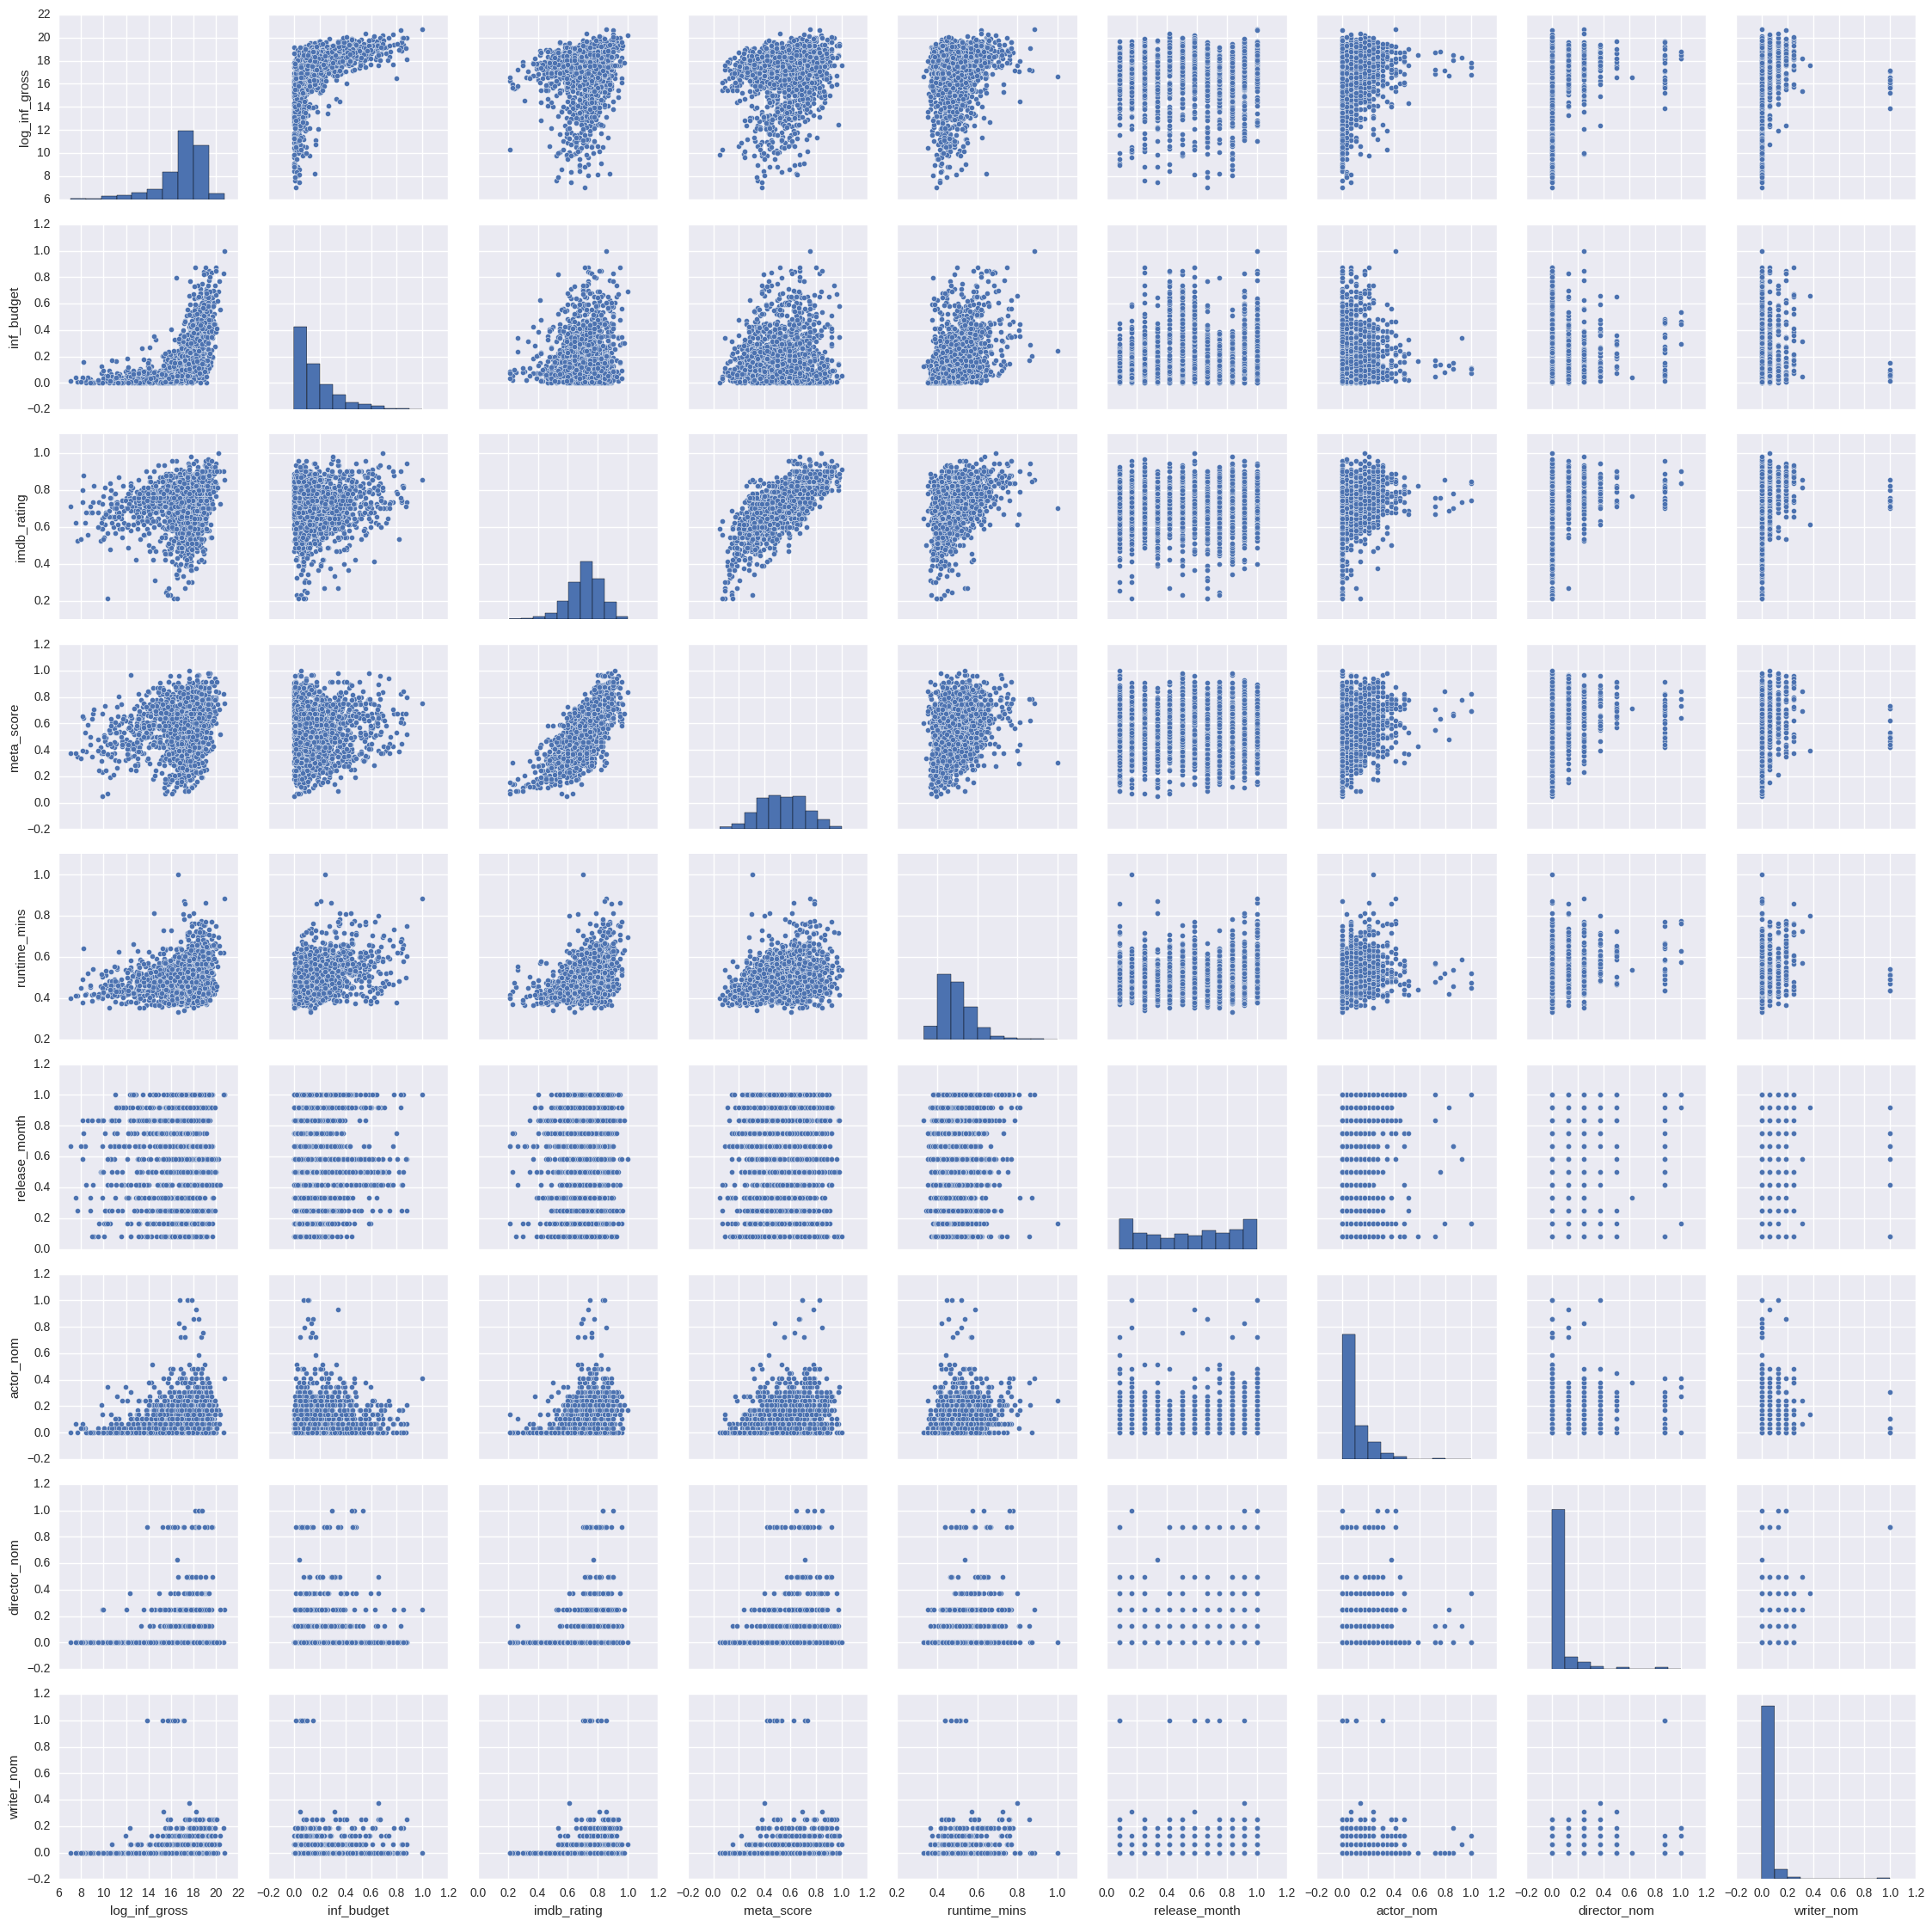

In [41]:
# pair plot
sns.pairplot(movies[['log_inf_gross', 'inf_budget', 'imdb_rating', 'meta_score', 'runtime_mins', 'release_month', 'actor_nom', 'director_nom', 'writer_nom']])

In [52]:
# create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create your model
model = sm.OLS(y_train, X_train)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_inf_gross   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     27.81
Date:                Thu, 26 Jan 2017   Prob (F-statistic):          1.11e-124
Time:                        07:22:50   Log-Likelihood:                -2407.5
No. Observations:                1263   AIC:                             4883.
Df Residuals:                    1229   BIC:                             5058.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
imdb_rating                2.1980      0.685      3.209      0.001         0.854     3.542
meta_score                 1.5130      0.421      3.592      0.000         0.687     2.339
runtime_mins               2.3513      0.856      2.746      0.006         0.671     4.031
release_month             -0.1204      0.166     -0.723      0.470        -0.447     0.206
inf_budget                 4.9615      0.424     11.692      0.000         4.129     5.794
Intercept                 13.5589      0.671     20.205      0.000        12.242    14.875
mpaa_rating[T.PG]         -0.2871      0.429     -0.669      0.504        -1.129     0.555
mpaa_rating[T.PG-13]      -0.6337      0.488     -1.297      0.195        -1.592     0.325
mpaa_rating[T.R]          -1.5590      0.495     -3.150      0.002        -2.530    -0.588
mpaa_rating[T.Unrated]    -5.7106      0.798     -7.159      0.000        -7.276    -4.146
actor_nom                  1.2290      0.443      2.774      0.006         0.360     2.098
director_nom               0.6319      0.434      1.457      0.145        -0.219     1.483
writer_nom                -0.4805      0.667     -0.720      0.472        -1.790     0.829
action                     0.4576      0.140      3.280      0.001         0.184     0.731
adventure                 -0.3007      0.161     -1.869      0.062        -0.616     0.015
animation                 -0.5139      0.337     -1.525      0.128        -1.175     0.147
biography                 -0.1247      0.203     -0.614      0.539        -0.523     0.274
comedy                     0.5048      0.131      3.848      0.000         0.247     0.762
crime                     -0.2346      0.135     -1.735      0.083        -0.500     0.031
documentary                0.5715      0.693      0.825      0.410        -0.788     1.931
drama                     -0.7796      0.127     -6.130      0.000        -1.029    -0.530
family                     0.2145      0.298      0.720      0.471        -0.370     0.799
fantasy                   -0.2281      0.161     -1.417      0.157        -0.544     0.088
history                    0.0364      0.283      0.129      0.897        -0.518     0.591
horror                     0.7049      0.181      3.898      0.000         0.350     1.060
music                      0.3314      0.246      1.346      0.178        -0.152     0.814
musical                   -0.2121      0.410     -0.518      0.605        -1.016     0.592
mystery                    0.1710      0.158      1.082      0.280        -0.139     0.481
romance                    0.1095      0.122      0.895      0.371        -0.131     0.350
sci_fi                    -0.3676      0.155     -2.373      0.018        -0.672    -0.064
sport                      0.2103      0.265      0.795      0.427        -0.309

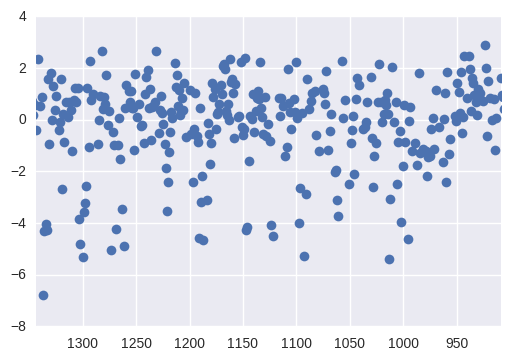

In [59]:
# plot residules
fit.resid.plot(style='o')
#plt.scatter(range(len(y_train)), y_train - fit.predict(X_train))

In [53]:
# use scikitlearn
lr = LinearRegression()
lr.fit(X_train, y_train)
# Print out the R^2 for the model against the full dataset
lr.score(X_test, y_test)

0.39947067791325697

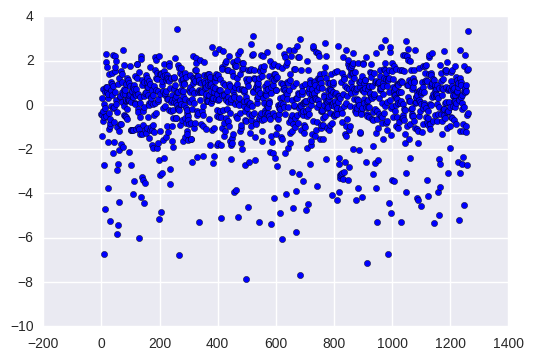

In [60]:
plt.scatter(range(len(lr.predict(X_train))), y_train - lr.predict(X_train))

In [56]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LinearRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()


ValueError: continuous is not supported

In [23]:
from sklearn.linear_model import Lasso

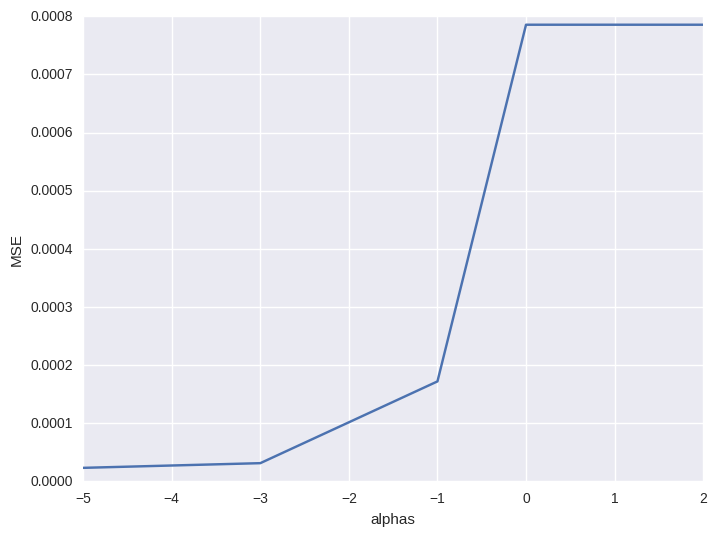

In [28]:
# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100]

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Lasso(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [29]:
all_mse

[2.3201399499582263e-05,
 3.1263897990874086e-05,
 0.00017191980310721553,
 0.0007855637483914739,
 0.0007855637483914739]

In [27]:
est=Lasso(alpha=1e-5)
est.fit(X_train,y_train)
est.alpha

zipped=zip(x_norm.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

[('inf_budget', 5.1172412623158152),
 (u'imdb_rating', 2.4643787301845563),
 (u'runtime_mins', 2.3700312687535869),
 ('actor_nom', 1.2537749146973434),
 (u'meta_score', 1.0343409671816002),
 (u'horror', 0.54786310121144499),
 (u'music', 0.53719604252288733),
 (u'family', 0.53305314849400121),
 (u'comedy', 0.51530948072341776),
 ('director_nom', 0.42569997486480549),
 (u'sport', 0.32734123024241124),
 (u'action', 0.28878624143539006),
 (u'thriller', 0.21927982504754057),
 (u'romance', 0.12068379423408326),
 (u'history', 0.1099578555216109),
 (u'mystery', 0.10502741840904106),
 (u'fantasy', 0.052444715433615514),
 (u'documentary', 0.0088055751337371112),
 ('Intercept', 0.0),
 (u'musical', -0.11164057260024172),
 (u'biography', -0.16556944923718769),
 (u'crime', -0.20107379186229229),
 ('mpaa_rating[T.PG-13]', -0.23398432005675651),
 ('mpaa_rating[T.PG]', -0.27025447632846544),
 (u'war', -0.30582572423230947),
 ('release_month', -0.31329734958356198),
 (u'adventure', -0.35189564209773483)